In [1]:
from load_data import load_data_cleansed
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR





In [2]:
price, listings, reviews = load_data_cleansed()

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:47: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:77: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  fil = listings["host_location"].str.contains(i, case = False, na = False)
/Users/dmn

In [3]:
listings.head()

,name,last_scraped,description,neighborhood_overview,host_name,host_since,host_about,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,host_location_country,bath_number,bath_kind,Bathtub,Bed linens,Breakfast,Cleaning before checkout,Dishwasher,Elevator,Hair dryer,Indoor fireplace,Long term stays allowed,Private entrance,Security cameras on property,Single level home,Special_stuff,TV_number,Outdoor_stuff_number,Baby_friendly,sound_system_number,Oven_available,Stoves_available,Refridgerator_available,Body_soap_available,Garden_backyard_available,Free_parking_number,Paid_parking_number,Children_Entertainment,Workspace,Shampoo_Conditioner_available,Fast_wifi_available,Gym_available,Coffee_machine_available,Dryer_available,Washer_available,Hot_tub_available,Pool_available,Patio_balcony_available,Wifi_available,AC_available,heating_available,Kitchen_available,Safe_available,Water_location
0,cosy comfortable Irish cottage twin,2021-11-08,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,Teresa,2010-08-06,"I am a friendly outgoing Irishwoman ,who love...",t,3.0,t,Dn Laoghaire-Rathdown,53.29178,-6.25792,Private room in bungalow,Private room,2,1.0,2.0,3,1125,t,0,0,22,202,227,0,0,2011-08-18,2020-02-08,4.77,4.82,4.72,4.92,4.66,4.82,f,3,1.82,Ireland,1.5,Shared,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,Cosy Comfortable Irish Cottage 1 Double Bed,2021-11-08,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",Teresa,2010-08-06,"I am a friendly outgoing Irishwoman ,who love...",t,3.0,t,Dn Laoghaire-Rathdown,53.29209,-6.25624,Private room in bungalow,Private room,2,1.0,1.0,3,21,t,0,0,21,296,182,0,0,2014-11-24,2020-02-09,4.79,4.85,4.72,4.88,4.66,4.80,f,3,2.15,Ireland,1.5,Shared,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,Friendly Single Room,2021-11-08,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,Margaret,2011-07-01,Used to host students and now I am looking fo...,f,0.0,t,Dublin City,53.39027,-6.23547,Private room in residential home,Private room,1,1.0,1.0,2,21,t,5,17,35,310,313,2,1,2014-05-20,2019-12-21,4.75,4.76,4.72,4.90,4.62,4.74,t,3,3.44,Ireland,2.0,Shared,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,5.5 miles south of Dublin City :^),2021-11-08,A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",Robert,2011-07-04,I live here on the third floor of my house. Th...,t,2.0,t,Dn Laoghaire-Rathdown,53.28326,-6.19188,Private room in townhouse,Private room,6,2.0,4.0,1,12,t,6,8,31,106,288,4,1,2015-07-18,2020-02-09,4.83,4.87,4.84,4.97,4.77,4.84,f,2,3.75,Ireland,1.5,Shared,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
5,Pádraig Pearse apt. Kilmainham,2021-11-08,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",Grainne,2011-07-07,"I'm Gráinne, originally from Co. Kildare and r...",t,5.0,t,Dublin City,53.33744,-6.32363,Enti

# Data format modification

We will ignore all text columns for now. So filter them out:

In [4]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]
listings = listings.drop(text_col, axis = 1)

Facing the NAs of the data, we observe that there are many missing values

In [5]:
na_values = listings.isna().sum().sort_values()
na_values.where(na_values > 100).dropna()

Shampoo_Conditioner_available     121.0
Workspace                         121.0
Children_Entertainment            121.0
sound_system_number               121.0
Free_parking_number               121.0
Garden_backyard_available         121.0
Oven_available                    121.0
Refridgerator_available           121.0
Stoves_available                  121.0
Paid_parking_number               121.0
Body_soap_available               121.0
Patio_balcony_available           121.0
Gym_available                     121.0
Coffee_machine_available          121.0
Dryer_available                   121.0
Washer_available                  121.0
Hot_tub_available                 121.0
Pool_available                    121.0
Baby_friendly                     121.0
Wifi_available                    121.0
AC_available                      121.0
heating_available                 121.0
Kitchen_available                 121.0
Fast_wifi_available               121.0
Outdoor_stuff_number              121.0


All review variables are problematic. Let's drop all of them for now

In [6]:
na_filter = listings.isna().any(axis = 1)
listings = listings[~na_filter]
price = price[~na_filter]
listings = listings.reset_index(drop = True)
listings.head()


,last_scraped,host_since,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,host_location_country,bath_number,bath_kind,Bathtub,Bed linens,Breakfast,Cleaning before checkout,Dishwasher,Elevator,Hair dryer,Indoor fireplace,Long term stays allowed,Private entrance,Security cameras on property,Single level home,Special_stuff,TV_number,Outdoor_stuff_number,Baby_friendly,sound_system_number,Oven_available,Stoves_available,Refridgerator_available,Body_soap_available,Garden_backyard_available,Free_parking_number,Paid_parking_number,Children_Entertainment,Workspace,Shampoo_Conditioner_available,Fast_wifi_available,Gym_available,Coffee_machine_available,Dryer_available,Washer_available,Hot_tub_available,Pool_available,Patio_balcony_available,Wifi_available,AC_available,heating_available,Kitchen_available,Safe_available,Water_location
0,2021-11-08,2010-08-06,t,3.0,t,Dn Laoghaire-Rathdown,53.29178,-6.25792,Private room in bungalow,Private room,2,1.0,2.0,3,1125,t,0,0,22,202,227,0,0,2011-08-18,2020-02-08,4.77,4.82,4.72,4.92,4.66,4.82,f,3,1.82,Ireland,1.5,Shared,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,2021-11-08,2010-08-06,t,3.0,t,Dn Laoghaire-Rathdown,53.29209,-6.25624,Private room in bungalow,Private room,2,1.0,1.0,3,21,t,0,0,21,296,182,0,0,2014-11-24,2020-02-09,4.79,4.85,4.72,4.88,4.66,4.80,f,3,2.15,Ireland,1.5,Shared,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2021-11-08,2011-07-01,f,0.0,t,Dublin City,53.39027,-6.23547,Private room in residential home,Private room,1,1.0,1.0,2,21,t,5,17,35,310,313,2,1,2014-05-20,2019-12-21,4.75,4.76,4.72,4.90,4.62,4.74,t,3,3.44,Ireland,2.0,Shared,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,2021-11-08,2011-07-04,t,2.0,t,Dn Laoghaire-Rathdown,53.28326,-6.19188,Private room in townhouse,Private room,6,2.0,4.0,1,12,t,6,8,31,106,288,4,1,2015-07-18,2020-02-09,4.83,4.87,4.84,4.97,4.77,4.84,f,2,3.75,Ireland,1.5,Shared,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,2021-11-08,2011-07-07,t,5.0,t,Dublin City,53.33744,-6.32363,Entire rental unit,Entire home/apt,5,1.0,3.0,4,365,t,11,18,41,283,50,7,1,2016-12-04,2017-01-25,4.56,4.86,4.68,4.72,4.30,4.46,f,5,0.83,Ireland,1.0,Normal,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


## Dates

Now let's deal with the date columns and turn them into numbers which give the difference to the last_scraped date

In [7]:
print(type(listings["last_scraped"][2]))
print(type(pd.to_datetime(listings["last_scraped"])[2]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


we have to turn every string into a datetime object

In [8]:
date_col = ["last_scraped","host_since","first_review", "last_review"]

pd.to_datetime(listings["last_scraped"], yearfirst = True)

0      2021-11-08
1      2021-11-08
2      2021-11-08
3      2021-11-08
4      2021-11-08
          ...    
4908   2021-11-08
4909   2021-11-08
4910   2021-11-08
4911   2021-11-08
4912   2021-11-08
Name: last_scraped, Length: 4913, dtype: datetime64[ns]

In [9]:
date_df = listings.filter(date_col).apply(pd.to_datetime)

In [10]:
date_df.head()

,last_scraped,host_since,first_review,last_review
0,2021-11-08,2010-08-06,2011-08-18,2020-02-08
1,2021-11-08,2010-08-06,2014-11-24,2020-02-09
2,2021-11-08,2011-07-01,2014-05-20,2019-12-21
3,2021-11-08,2011-07-04,2015-07-18,2020-02-09
4,2021-11-08,2011-07-07,2016-12-04,2017-01-25


Now we can calculate the time delta

In [11]:
date_df["last_scraped"]-date_df["first_review"]

0      3735 days
1      2541 days
2      2729 days
3      2305 days
4      1800 days
          ...   
4908     50 days
4909     15 days
4910     34 days
4911     42 days
4912     14 days
Length: 4913, dtype: timedelta64[ns]

In [12]:
listings["host_since"] = date_df["last_scraped"]-date_df["host_since"]
listings["first_review"] = date_df["last_scraped"]-date_df["first_review"]
listings["last_review"] = date_df["last_scraped"]-date_df["last_review"]

In [13]:
listings.filter(date_col).head()

,last_scraped,host_since,first_review,last_review
0,2021-11-08,4112 days,3735 days,639 days
1,2021-11-08,4112 days,2541 days,638 days
2,2021-11-08,3783 days,2729 days,688 days
3,2021-11-08,3780 days,2305 days,638 days
4,2021-11-08,3777 days,1800 days,1748 days


We don't use the last_scraped column any longer

In [14]:
listings = listings.drop("last_scraped", axis = 1)

We have a timedelta object in each cell now. We should convert it into an integer using its attribute .days

In [15]:
date_col = date_col[1:]
for i in date_col:
    listings[i] = pd.Series([j.days for j in list(listings[i])])


## Categories

Next we have to create dummies for the categorical variables in order to use them for models like RandomForests, Ridge,...

In [16]:
listings.head()

,host_since,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,host_location_country,bath_number,bath_kind,Bathtub,Bed linens,Breakfast,Cleaning before checkout,Dishwasher,Elevator,Hair dryer,Indoor fireplace,Long term stays allowed,Private entrance,Security cameras on property,Single level home,Special_stuff,TV_number,Outdoor_stuff_number,Baby_friendly,sound_system_number,Oven_available,Stoves_available,Refridgerator_available,Body_soap_available,Garden_backyard_available,Free_parking_number,Paid_parking_number,Children_Entertainment,Workspace,Shampoo_Conditioner_available,Fast_wifi_available,Gym_available,Coffee_machine_available,Dryer_available,Washer_available,Hot_tub_available,Pool_available,Patio_balcony_available,Wifi_available,AC_available,heating_available,Kitchen_available,Safe_available,Water_location
0,4112,t,3.0,t,Dn Laoghaire-Rathdown,53.29178,-6.25792,Private room in bungalow,Private room,2,1.0,2.0,3,1125,t,0,0,22,202,227,0,0,3735,639,4.77,4.82,4.72,4.92,4.66,4.82,f,3,1.82,Ireland,1.5,Shared,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,4112,t,3.0,t,Dn Laoghaire-Rathdown,53.29209,-6.25624,Private room in bungalow,Private room,2,1.0,1.0,3,21,t,0,0,21,296,182,0,0,2541,638,4.79,4.85,4.72,4.88,4.66,4.80,f,3,2.15,Ireland,1.5,Shared,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3783,f,0.0,t,Dublin City,53.39027,-6.23547,Private room in residential home,Private room,1,1.0,1.0,2,21,t,5,17,35,310,313,2,1,2729,688,4.75,4.76,4.72,4.90,4.62,4.74,t,3,3.44,Ireland,2.0,Shared,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,3780,t,2.0,t,Dn Laoghaire-Rathdown,53.28326,-6.19188,Private room in townhouse,Private room,6,2.0,4.0,1,12,t,6,8,31,106,288,4,1,2305,638,4.83,4.87,4.84,4.97,4.77,4.84,f,2,3.75,Ireland,1.5,Shared,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,3777,t,5.0,t,Dublin City,53.33744,-6.32363,Entire rental unit,Entire home/apt,5,1.0,3.0,4,365,t,11,18,41,283,50,7,1,1800,1748,4.56,4.86,4.68,4.72,4.30,4.46,f,5,0.83,Ireland,1.0,Normal,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [17]:
cat_col = ["host_is_superhost", "host_identity_verified", "neighbourhood_cleansed", "property_type", "room_type", "has_availability", "instant_bookable", "host_location_country", "bath_kind"]


Best approach might be to convert all categories into dummy_variables. Let's see how man categories there are for each variables

In [18]:
for i in cat_col:
    print(listings[i].value_counts())

f    3846
t    1067
Name: host_is_superhost, dtype: int64
t    3624
f    1289
Name: host_identity_verified, dtype: int64
Dublin City              3737
Dn Laoghaire-Rathdown     525
Fingal                    473
South Dublin              178
Name: neighbourhood_cleansed, dtype: int64
Entire rental unit                     1201
Private room in residential home       1000
Private room in rental unit             880
Entire residential home                 700
Private room in townhouse               193
Entire townhouse                        186
Entire condominium (condo)              182
Private room in condominium (condo)     104
Others                                  104
Private room in bed and breakfast        59
Entire serviced apartment                51
Entire cottage                           40
Entire guest suite                       37
Private room in bungalow                 37
Entire bungalow                          23
Entire guesthouse                        22
Entire loft 

That looks fine. Let's define a function that sets up the dummies and drops the category column:

In [19]:
def to_dummy_single(df, X, output_name):
    dummies = pd.get_dummies(df[X])
    dummies.columns = output_name + "_" + dummies.columns

    if len(dummies.columns) == 2:
        dummies = dummies[dummies.columns[0]]

    df = df.join(dummies)
    df = df.drop(X, axis = 1)

    return df

def to_dummy(df, X_list, output_names):
    for i in range(len(X_list)):
        df = to_dummy_single(df, X_list[i], output_names[i])
    
    return df



In [20]:
listings = to_dummy(listings, cat_col, cat_col)
listings.head()

,host_since,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,bath_number,Bathtub,Bed linens,Breakfast,Cleaning before checkout,Dishwasher,Elevator,Hair dryer,Indoor fireplace,Long term stays allowed,Private entrance,Security cameras on property,Single level home,Special_stuff,TV_number,Outdoor_stuff_number,Baby_friendly,sound_system_number,Oven_available,Stoves_available,Refridgerator_available,Body_soap_available,Garden_backyard_available,Free_parking_number,Paid_parking_number,Children_Entertainment,Workspace,Shampoo_Conditioner_available,Fast_wifi_available,Gym_available,Coffee_machine_available,Dryer_available,Washer_available,Hot_tub_available,Pool_available,Patio_balcony_available,Wifi_available,AC_available,heating_available,Kitchen_available,Safe_available,Water_location,host_is_superhost_f,host_identity_verified_f,neighbourhood_cleansed_Dn Laoghaire-Rathdown,neighbourhood_cleansed_Dublin City,neighbourhood_cleansed_Fingal,neighbourhood_cleansed_South Dublin,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire condominium (condo),property_type_Entire cottage,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire loft,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Others,property_type_Private room,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in cabin,property_type_Private room in condominium (condo),property_type_Private room in cottage,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Private room in townhouse,property_type_Tiny house,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,has_availability_f,instant_bookable_f,host_location_country_Argentina,host_location_country_Australia,host_location_country_Belgium,host_location_country_Brazil,host_location_country_Bulgaria,host_location_country_Canada,host_location_country_Croatia,host_location_country_France,host_location_country_Germany,host_location_country_India,host_location_country_Ireland,host_location_country_Israel,host_location_country_Italy,host_location_country_Mexico,host_location_country_Netherlands,host_location_country_Others,host_location_country_Poland,host_location_country_Portugal,host_location_country_Spain,host_location_country_Sweden,host_location_country_Switzerland,host_location_country_Turkey,host_location_country_United Kingdom,host_location_country_United States,bath_kind_Normal,bath_kind_Private,bath_kind_Shared
0,4112,3.0,53.29178,-6.25792,2,1.0,2.0,3,1125,0,0,22,202,227,0,0,3735,639,4.77,4.82,4.72,4.92,4.66,4.82,3,1.82,1.5,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,4112,3.0,53.29209,-6.25624,2,1.0,1.0,3,21,0,0,21,296,182,0,0,2541,638,4.79,4.85,4.72,4.88,4.66,4.80,3,2.15,1.5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3783,0.0,53.39027,-6.23547,1,1.0,1.0,2,21,5,17,35,310,313,2,1,2729,688,4.7

In [21]:
listings.dtypes

host_since                                int64
host_listings_count                     float64
latitude                                float64
longitude                               float64
accommodates                              int64
                                         ...   
host_location_country_United Kingdom      uint8
host_location_country_United States       uint8
bath_kind_Normal                          uint8
bath_kind_Private                         uint8
bath_kind_Shared                          uint8
Length: 130, dtype: object

seems like we have only numeric data types in our listings. Lets head over to the selection

# Variable Selection

## Random Forest Model

In [22]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings, price, random_state = 123)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.3611911122291921

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [23]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_23762/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


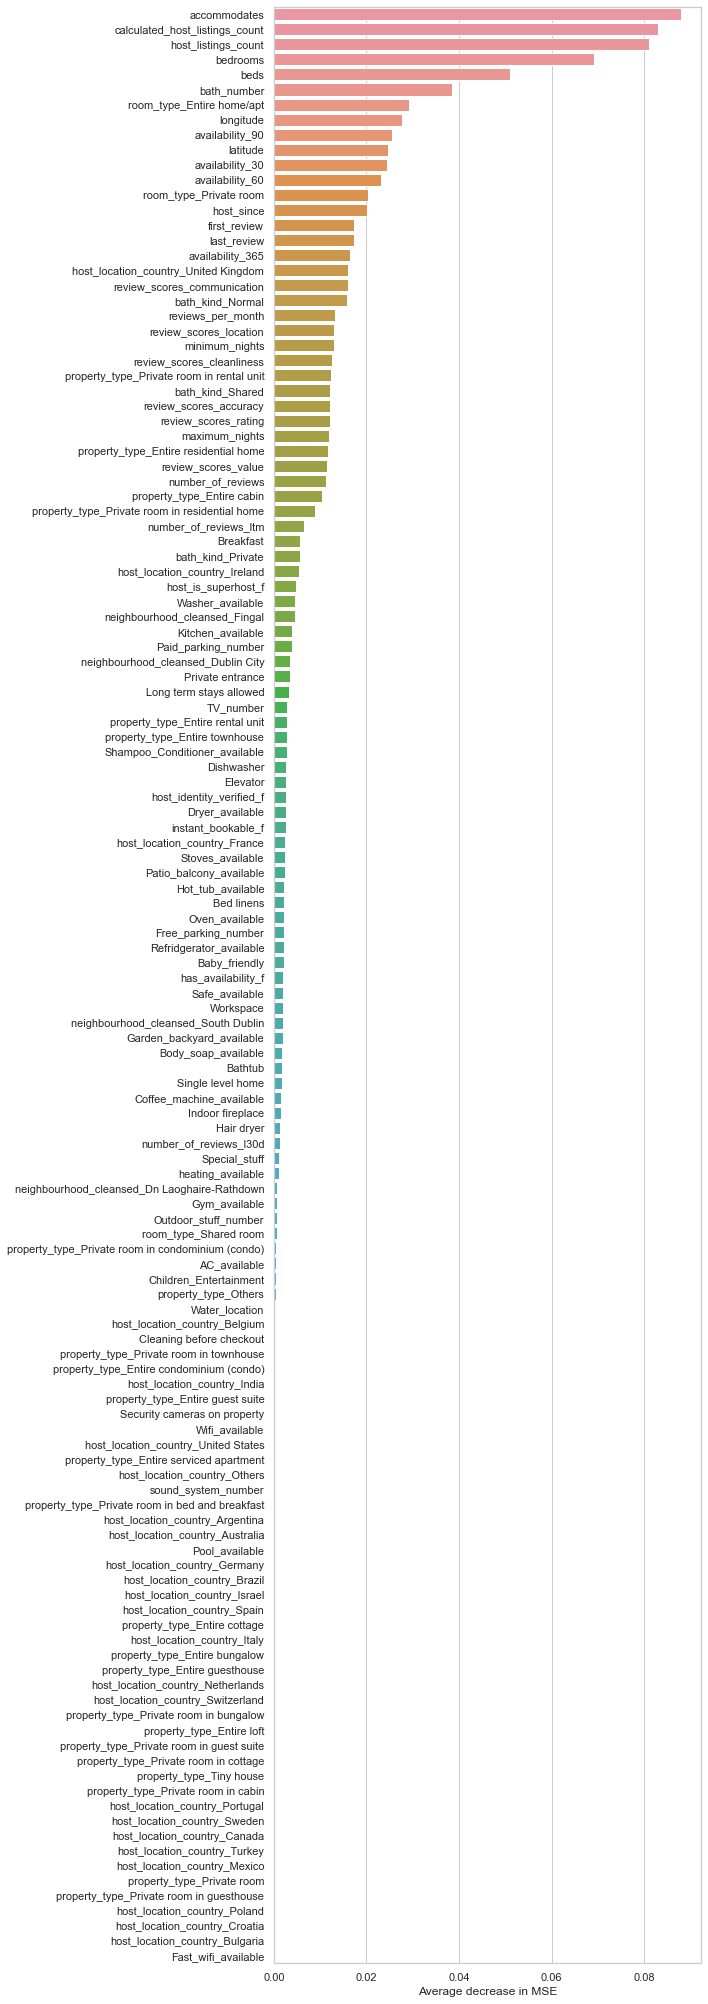

In [24]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

The blue bars of the diagram indicate by how much the impurity was decreased on average when using the feature in a tree. The black lines give the standard deviation
Problem of the importance measure: We only consider the training data and how important each feature is on average for the training model. 

Therefore we also use another approach. We take the test data and shuffle a feature randomly and evaluate the mode score. Thereby we cut the connection between target and feature. If the model accuracy/MSE decreases significantly the feature might be important for the prediction.

### Permutation approach

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_23762/1120045921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


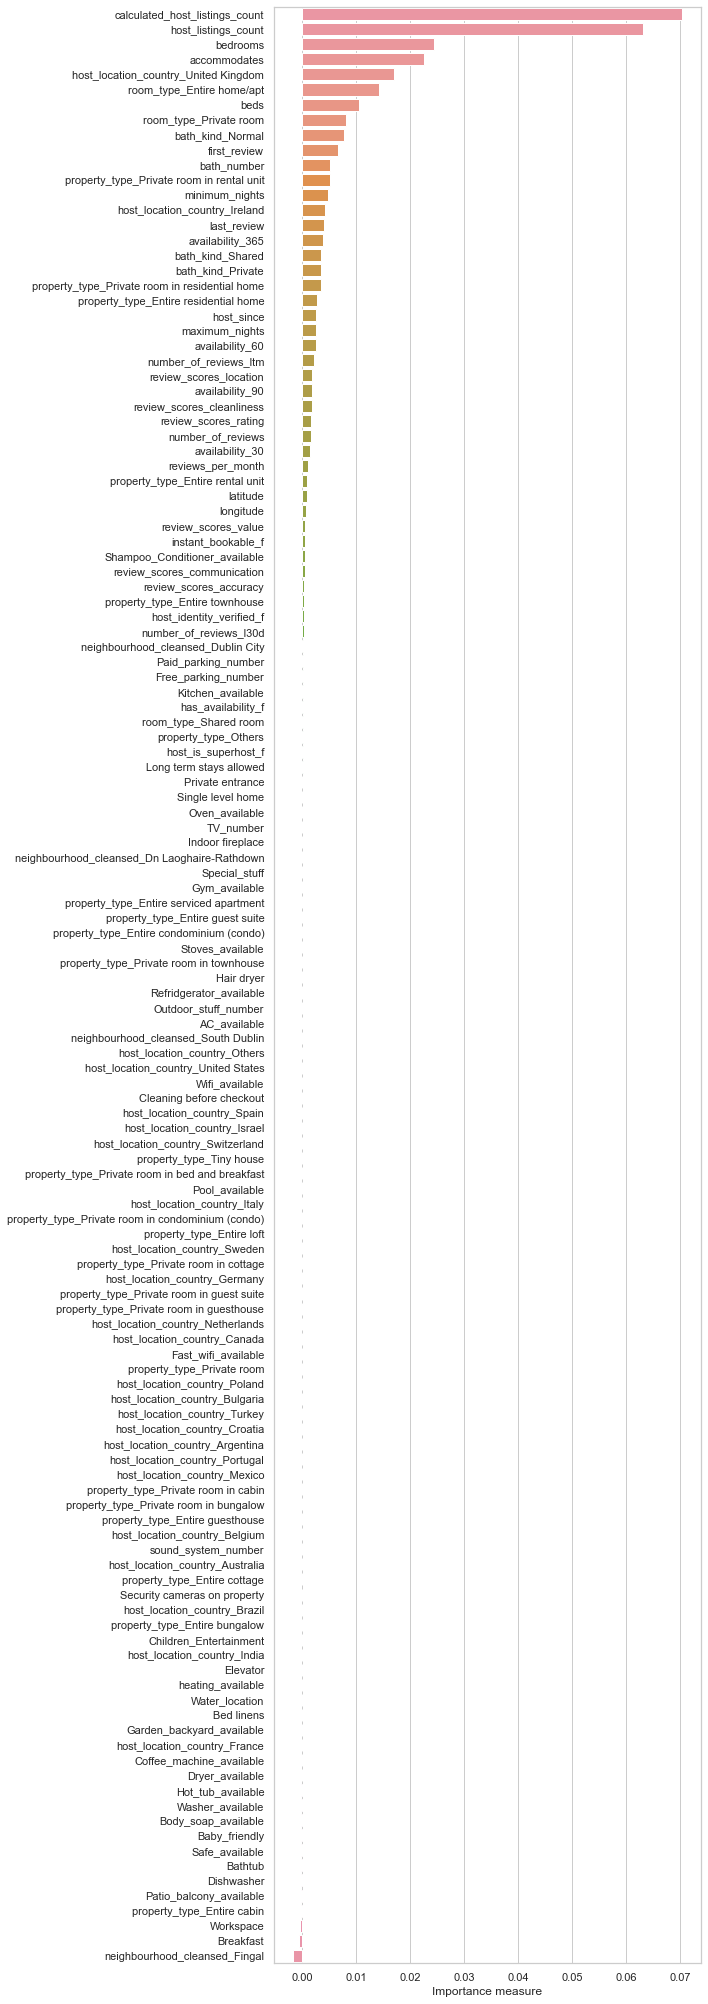

In [25]:
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Ridge with Kernel model
Let's repeat the permutation approach for several other algorithms

### rbf kernel

In [26]:
# train Ridge Kernel model
rbf_ridge = KernelRidge(kernel = "rbf", alpha = 0)
rbf_ridge.fit(X_train, y_train)
rbf_ridge.score(X_test, y_test)

-0.18560262530185812

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_23762/1598192241.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


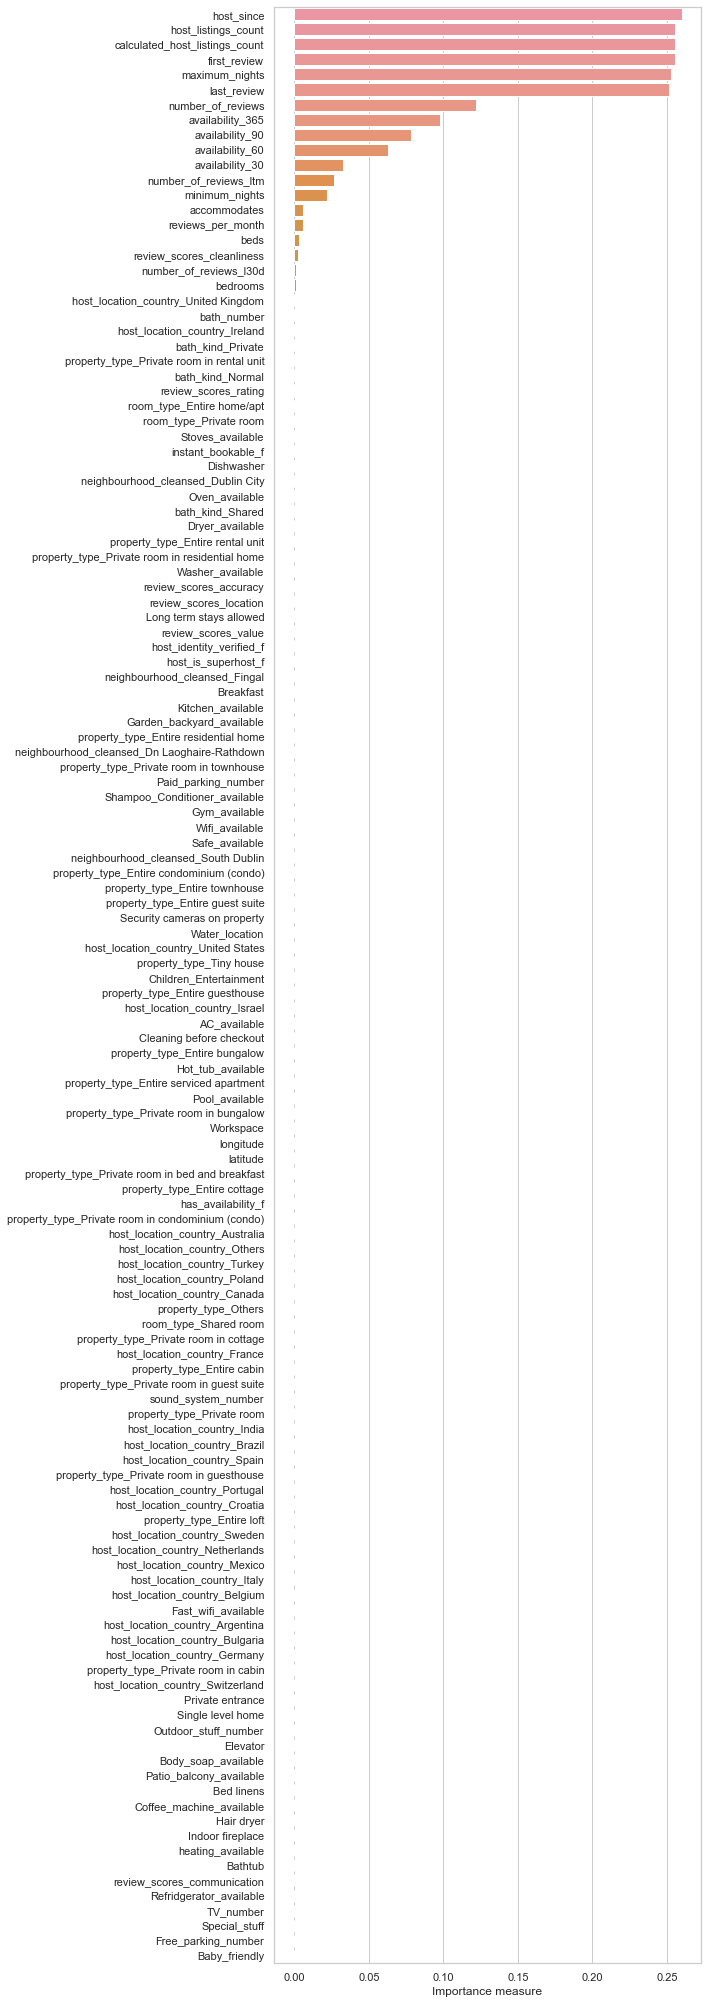

In [27]:
result = permutation_importance(rbf_ridge, X_test, y_test, n_repeats=10, random_state=42)
rbf_ridge_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = rbf_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

### linear kernel

In [28]:
# train Ridge Kernel model
linear_ridge = KernelRidge(kernel = "linear")
linear_ridge.fit(X_train, y_train)
linear_ridge.score(X_test, y_test)

0.27655278084770973

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_23762/3969062155.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


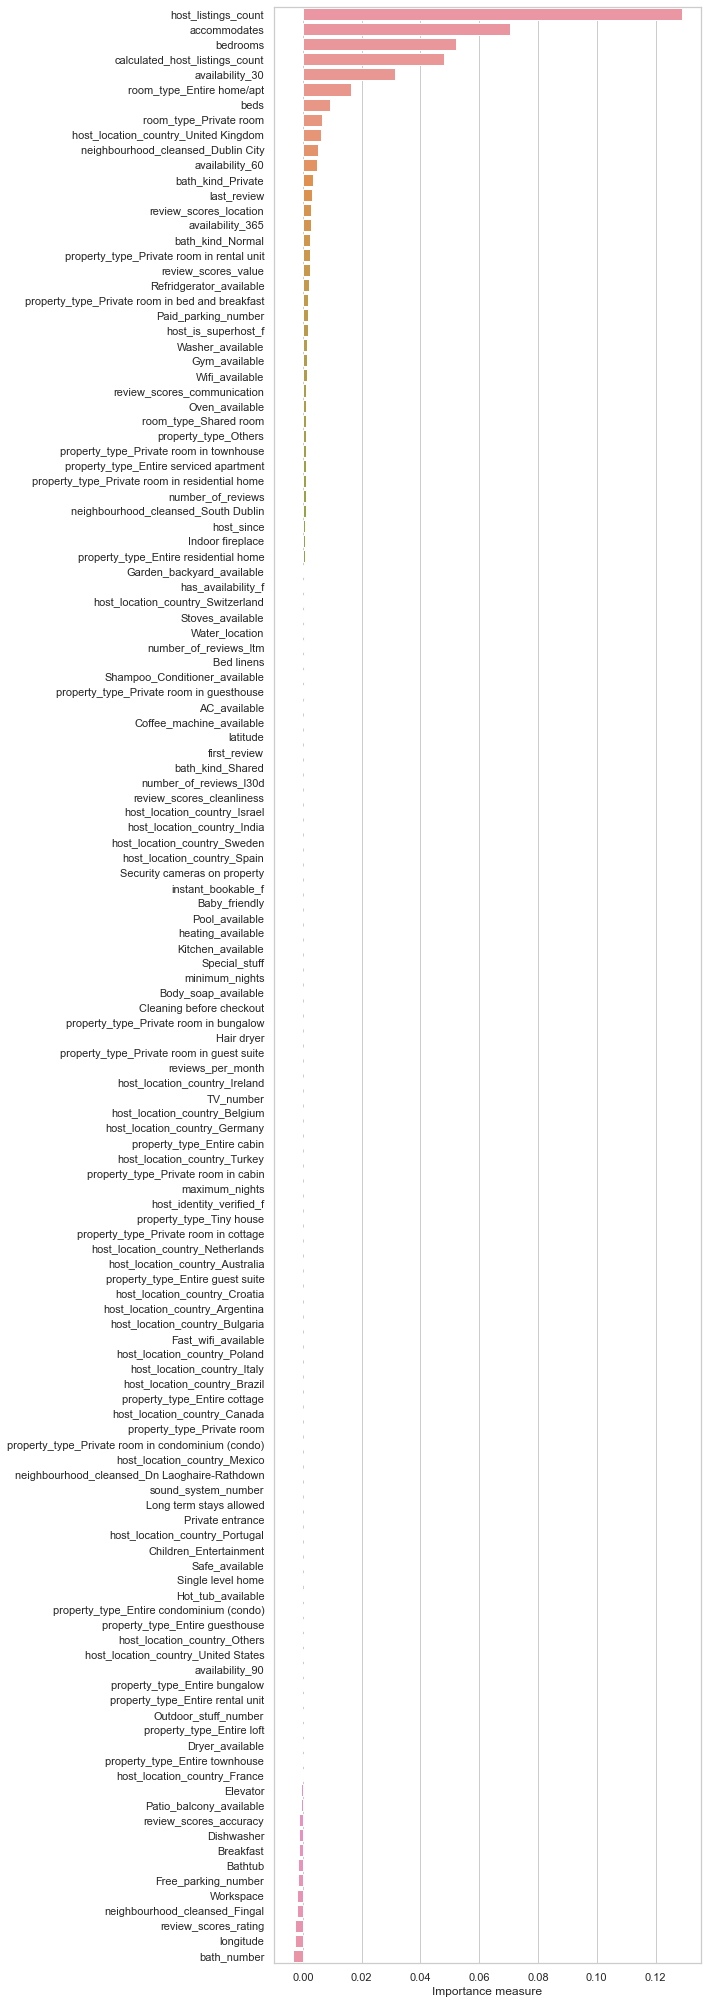

In [29]:
result = permutation_importance(linear_ridge, X_test, y_test, n_repeats=10, random_state=42)
linear_ridge_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = linear_ridge_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## SVR
### rbf kernel

In [30]:
# train Ridge Kernel model
rbf_svr= SVR(kernel = "rbf")
rbf_svr.fit(X_train, y_train)
rbf_svr.score(X_test, y_test)

-0.041722577604758726

In [31]:
#result = permutation_importance(rbf_svr, X_test, y_test, n_repeats=10, random_state=42, scoring = "r2")
#rbf_svr_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
#plot_data = rbf_svr_importances.sort_values(ascending=False)

# plotting
#sn.set_theme(style = "whitegrid")
#fig, ax = plt.subplots(figsize = (10,28))
#sn.barplot(x=plot_data.values, y=plot_data.index)
#ax.set_xlabel("Importance measure")
#fig.tight_layout()
#fig.show()

In [32]:
# train Ridge Kernel model
linear_svr= LinearSVR(max_iter = 100000)
linear_svr.fit(X_train, y_train)
linear_svr.score(X_test, y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.3244972511252987

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_23762/827178593.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


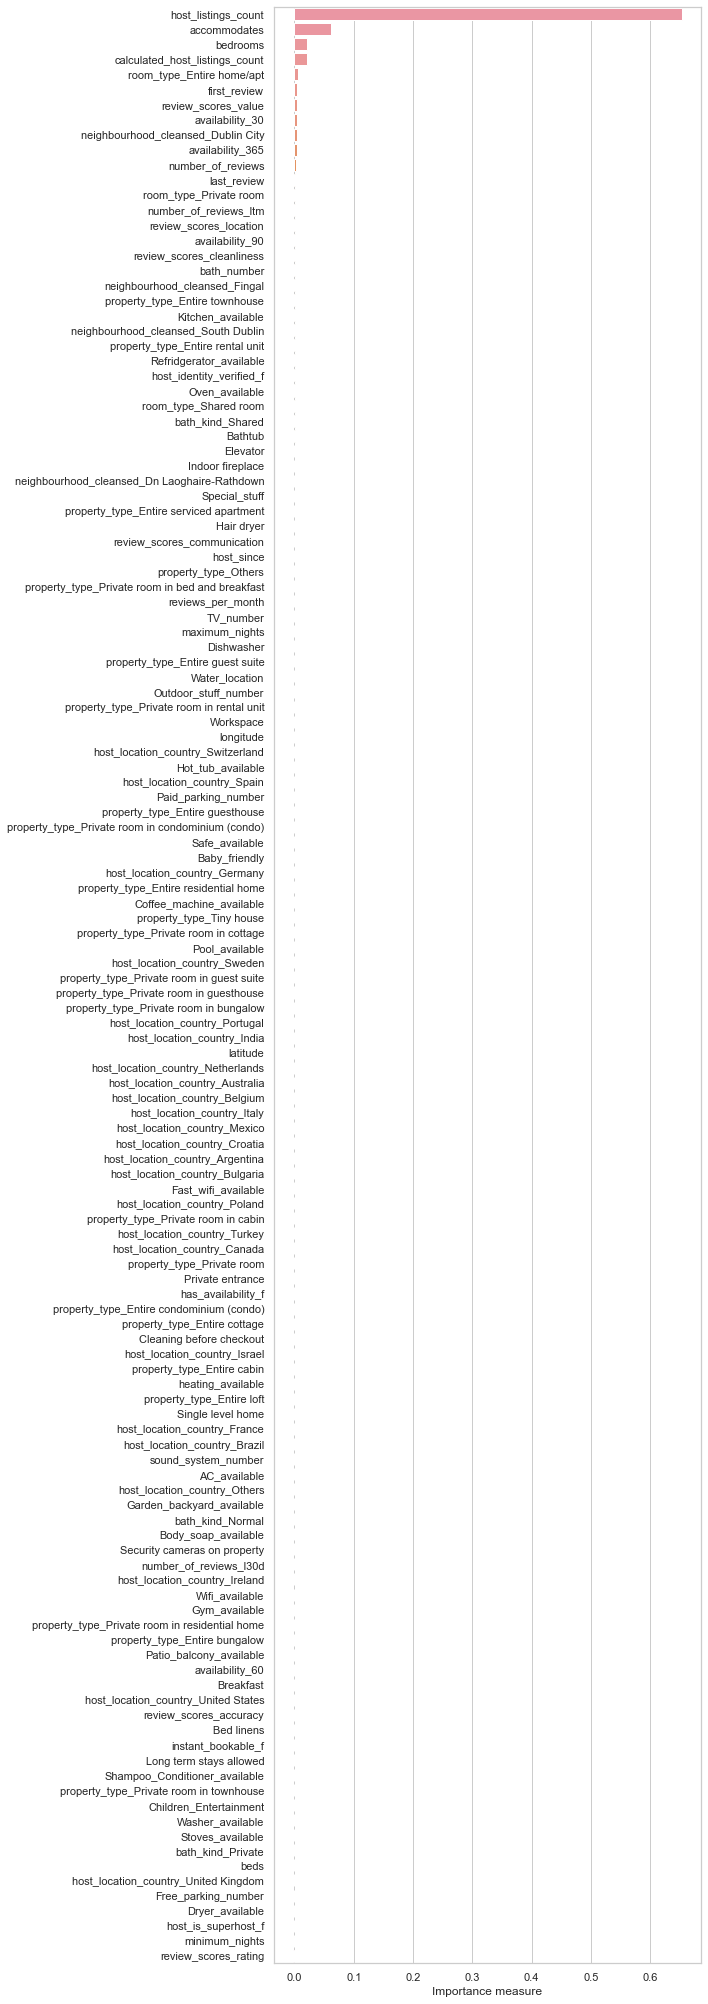

In [33]:
result = permutation_importance(linear_svr, X_test, y_test, n_repeats=10, random_state=42, scoring = "r2")
linear_svr_importances = pd.Series(result.importances_mean, index=listings.columns)
# sort the features by their importance
plot_data = linear_svr_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Boosting

In [34]:
params = {
    "n_estimators": 1500,
    "max_depth": 2,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

In [35]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.33180790176209063

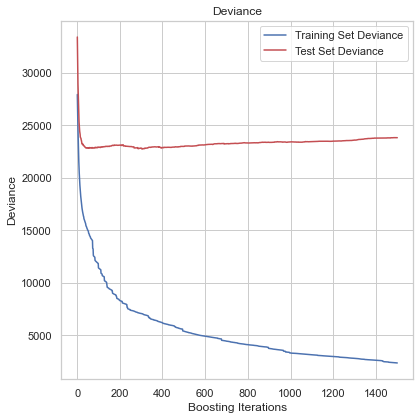

In [36]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

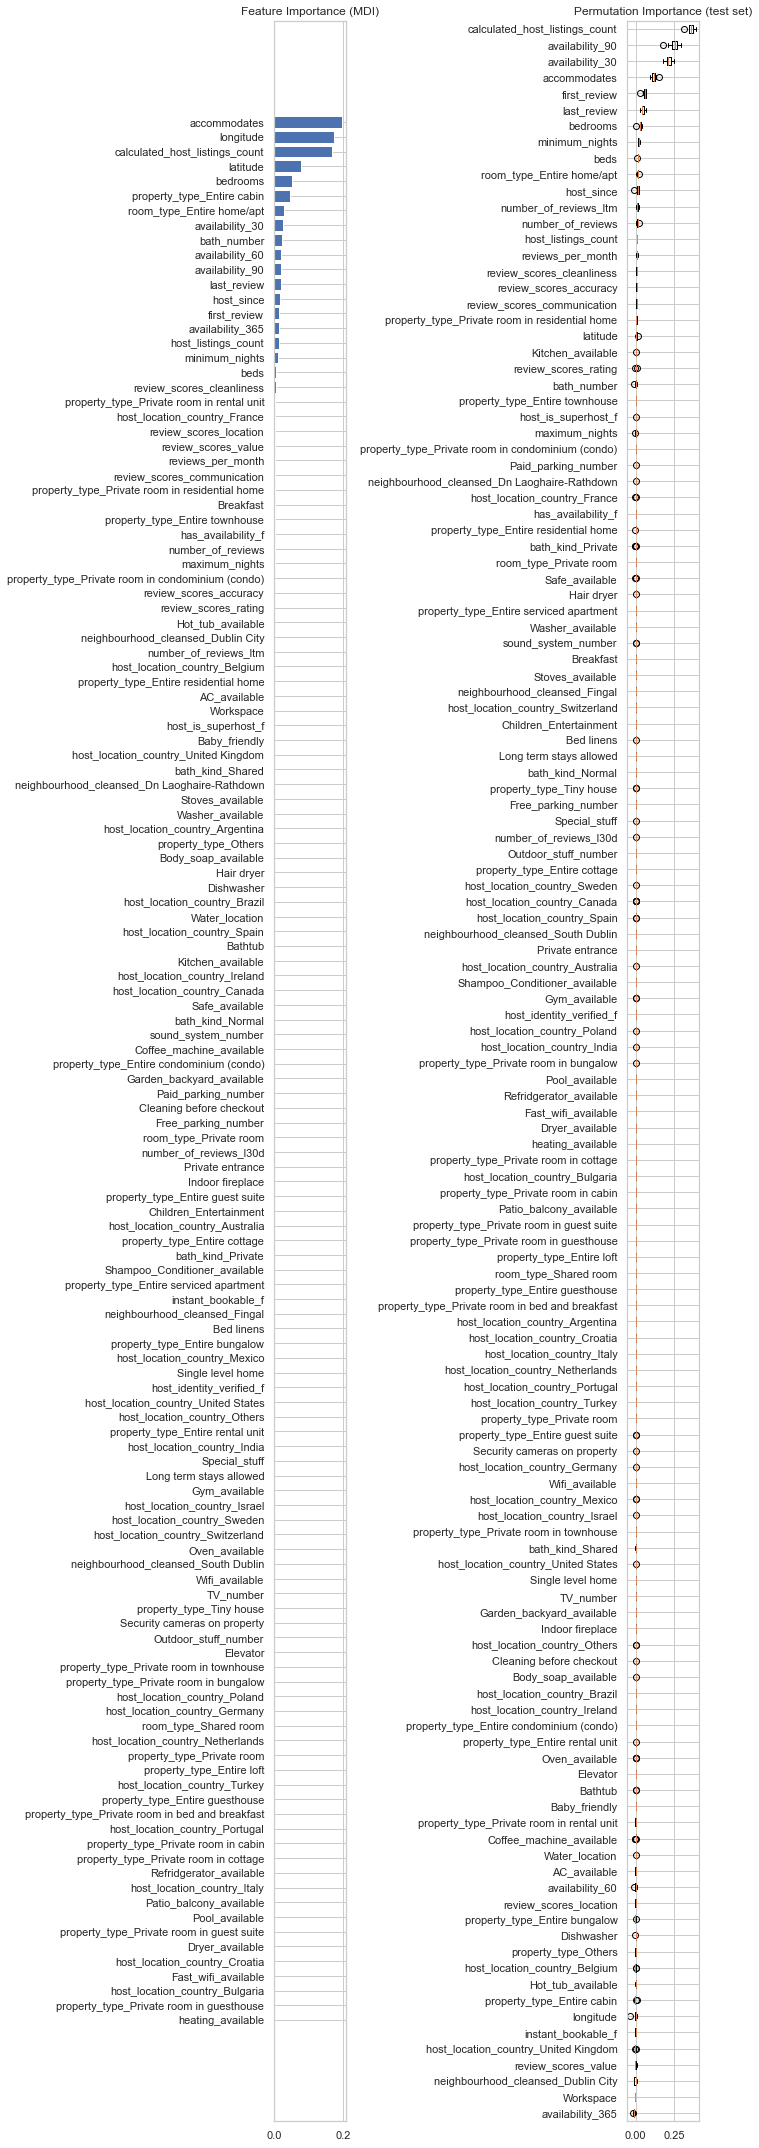

In [37]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(10, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(listings.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(listings.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

The problem of this method is that the importance of highly correlated amenities disappears as shuffling the first feature the model could still get the information by the second correlated feature. 
This can be the case for our data. For instance the possibility to stay for a longer time might be highly correlated with the availability of a washing machine or having a kitchen and an oven.

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

We should take the correlation of the variables into account. Therefore we need different approaches dependent on the scale of variables
- pearson: numeric and numeric 
- jaccard: binary and binary
- point-biserial: binary and numeric

In [38]:
listings.columns.values

array(['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'bath_number', 'Bathtub', 'Bed linens', 'Breakfast',
       'Cleaning before checkout', 'Dishwasher', 'Elevator', 'Hair dryer',
       'Indoor fireplace', 'Long term stays allowed', 'Private entrance',
       'Security cameras on property', 'Single level home',
       'Special_stuff', 'TV_number', 'Outdoor_stuff_number',
       'Baby_friendly', 'sound_system_number', 'Oven_available',
       'Stoves

In [39]:
num_col = ['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'bath_number', 'Special_stuff', 'TV_number', 'Outdoor_stuff_number',
       'Baby_friendly', 'sound_system_number', 'Free_parking_number', 'Paid_parking_number']


catg_col = ['Bathtub', 'Bed linens', 'Breakfast',
       'Cleaning before checkout', 'Dishwasher', 'Elevator', 'Hair dryer',
       'Indoor fireplace', 'Long term stays allowed', 'Private entrance',
       'Security cameras on property', 'Single level home', 'Oven_available',
       'Stoves_available', 'Refridgerator_available',
       'Body_soap_available', 'Garden_backyard_available',  'Children_Entertainment', 'Workspace',
       'Shampoo_Conditioner_available', 'Fast_wifi_available',
       'Gym_available', 'Coffee_machine_available', 'Dryer_available',
       'Washer_available', 'Hot_tub_available', 'Pool_available',
       'Patio_balcony_available', 'Wifi_available', 'AC_available',
       'heating_available', 'Kitchen_available', 'Safe_available',
       'Water_location', 'host_is_superhost_f',
       'host_identity_verified_f',
       'neighbourhood_cleansed_Dn Laoghaire-Rathdown',
       'neighbourhood_cleansed_Dublin City',
       'neighbourhood_cleansed_Fingal',
       'neighbourhood_cleansed_South Dublin',
       'property_type_Entire bungalow', 'property_type_Entire cabin',
       'property_type_Entire condominium (condo)',
       'property_type_Entire cottage', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'property_type_Entire loft',
       'property_type_Entire rental unit',
       'property_type_Entire residential home',
       'property_type_Entire serviced apartment',
       'property_type_Entire townhouse', 'property_type_Others',
       'property_type_Private room',
       'property_type_Private room in bed and breakfast',
       'property_type_Private room in bungalow',
       'property_type_Private room in cabin',
       'property_type_Private room in condominium (condo)',
       'property_type_Private room in cottage',
       'property_type_Private room in guest suite',
       'property_type_Private room in guesthouse',
       'property_type_Private room in rental unit',
       'property_type_Private room in residential home',
       'property_type_Private room in townhouse',
       'property_type_Tiny house', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'has_availability_f', 'instant_bookable_f',
       'host_location_country_Argentina',
       'host_location_country_Australia', 'host_location_country_Belgium',
       'host_location_country_Brazil', 'host_location_country_Bulgaria',
       'host_location_country_Canada', 'host_location_country_Croatia',
       'host_location_country_France', 'host_location_country_Germany',
       'host_location_country_India', 'host_location_country_Ireland',
       'host_location_country_Israel', 'host_location_country_Italy',
       'host_location_country_Mexico',
       'host_location_country_Netherlands',
       'host_location_country_Others', 'host_location_country_Poland',
       'host_location_country_Portugal', 'host_location_country_Spain',
       'host_location_country_Sweden',
       'host_location_country_Switzerland',
       'host_location_country_Turkey',
       'host_location_country_United Kingdom',
       'host_location_country_United States', 'bath_kind_Normal',
       'bath_kind_Private', 'bath_kind_Shared']


In [40]:
# sanity check
len(num_col + catg_col) == len(listings.columns)

True

## Pearson Correlation

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_23762/4128672555.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im)


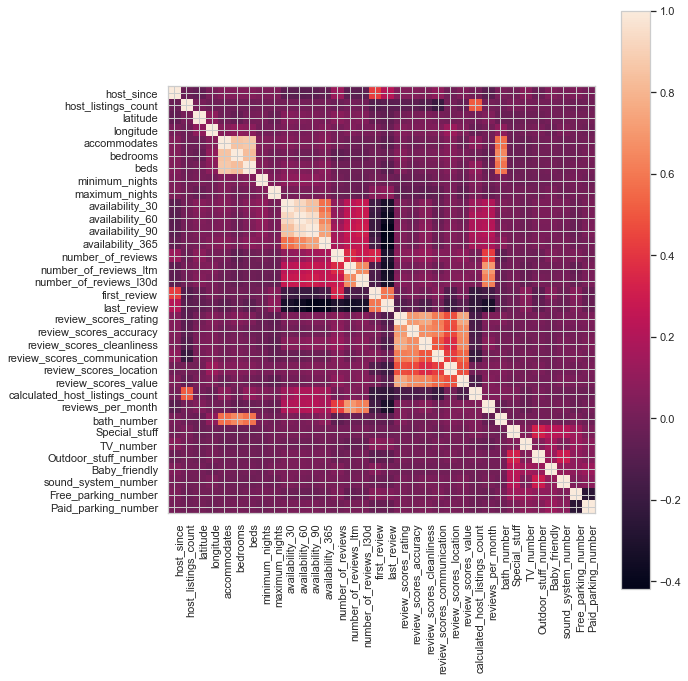

In [41]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(listings.filter(num_col).corr())
ax.figure.colorbar(im)
ax.set_xticks(np.arange(len(num_col)), labels=num_col)
ax.set_yticks(np.arange(len(num_col)), labels=num_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.tight_layout()
plt.show()

## Jaccard Correlation

At first lets define a function that calculates the Jaccard Correlation coefficient

In [42]:
def jac(x,y):
    a = ((x == 1) == (y == 1)).sum()
    b = ((x == 1) == (y == 0)).sum()
    c = ((x == 0) == (y == 1)).sum()
    #d = ((x == 0) == (y == 0)).sum()

    j = a/(a+b+c)

    return j

Now calculate the coefficient for each combination of binary covariables

In [43]:
binary_df = listings.filter(catg_col)

# init matrix
A = np.zeros((len(catg_col), len(catg_col)))

for i, a in enumerate(catg_col):
    for j, b in enumerate(catg_col):
        A[i,j] = jac(binary_df[a], binary_df[b])


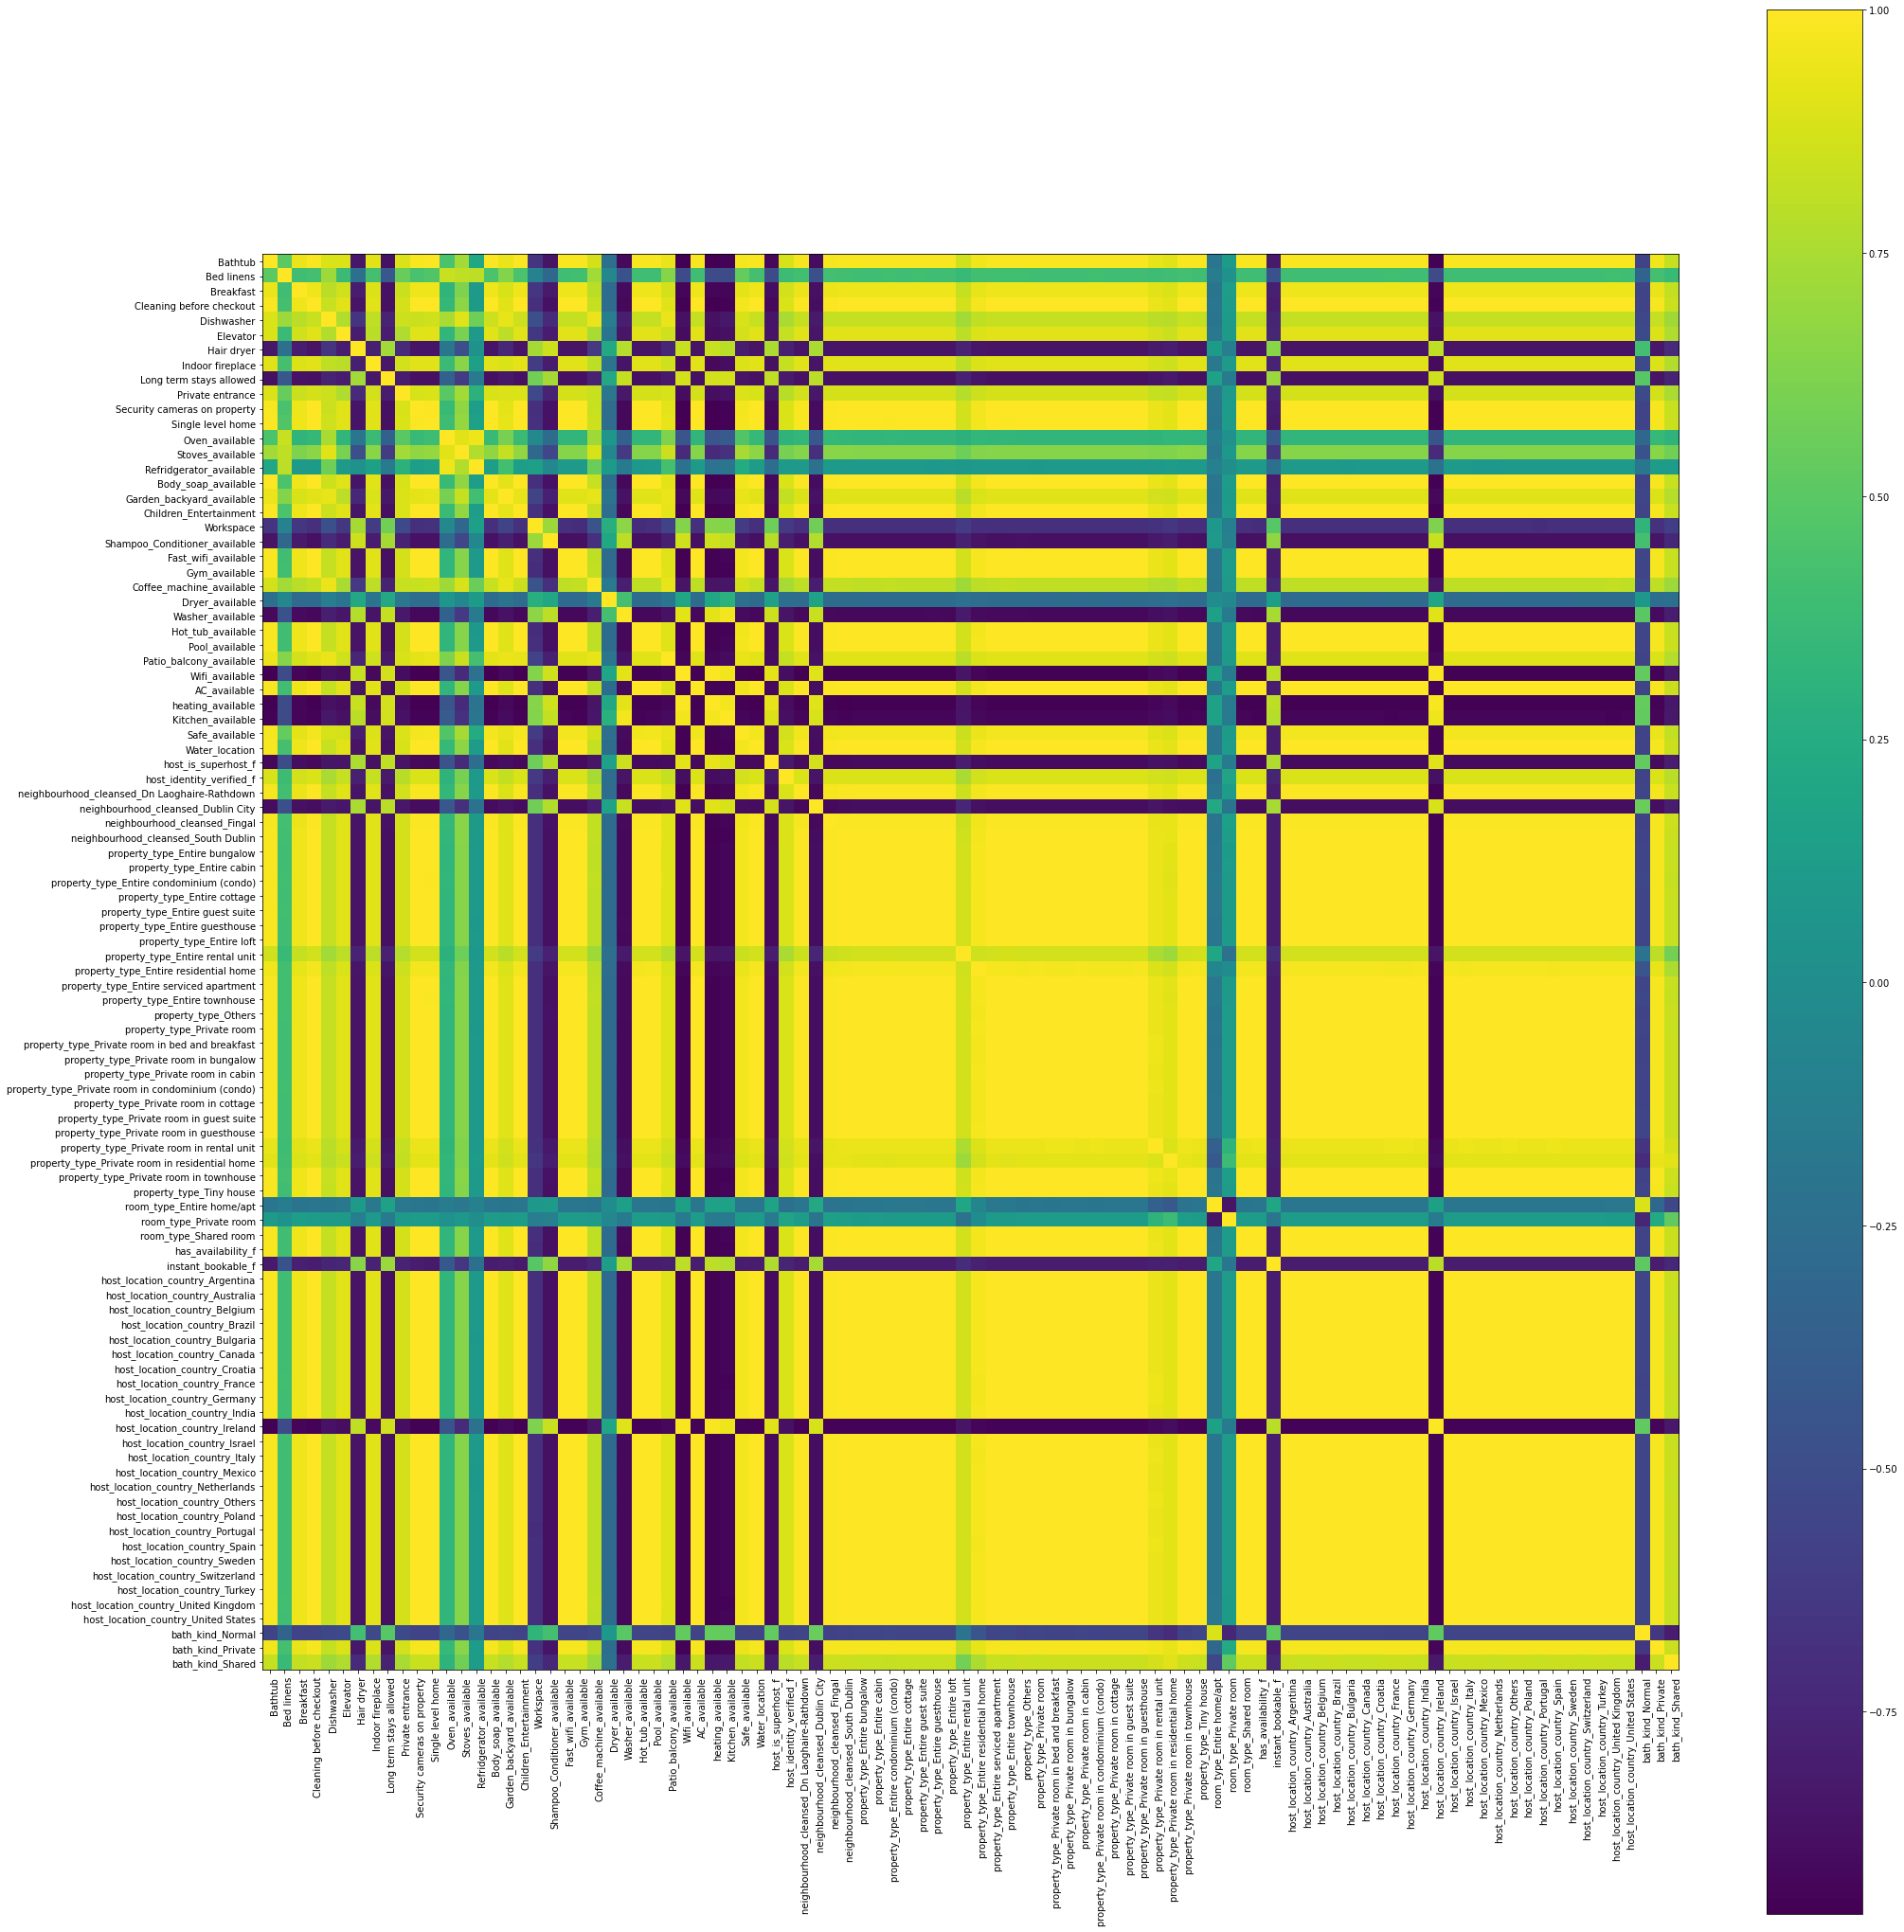

In [77]:
jac_df = pd.DataFrame(A)

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(jac_df.corr())
ax.figure.colorbar(im)
ax.set_xticks(np.arange(len(catg_col)), labels=catg_col)
ax.set_yticks(np.arange(len(catg_col)), labels=catg_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.tight_layout()
plt.show()